In [68]:
import os
import pandas as pd
import numpy as np

import librosa
import matplotlib.pyplot as plt

from IPython.display import Audio
# !pip install pydub
from pydub import AudioSegment, effects
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import layers, optimizers, callbacks
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.style.use('ggplot')

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [69]:
rav_path = "./Ravdess/audio_speech_actors_01-24/"

In [70]:
root_dir = "./Ravdess"

# Recursively search for .DS_Store files and delete them
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file == ".DS_Store":
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"{file_path} has been deleted.")

print("Deletion process completed.")


Deletion process completed.


In [71]:
ravdess_directory_list = os.listdir(rav_path)
file_path_list = []
gender_list = []
emotion_label_list = []

emotion_dictionary = {
    '03': 'happy',
    '01': 'neutral',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust',
}

for directory in ravdess_directory_list:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files:
        file_name_parts = audio_file.split('.')[0].split('-')
        key = file_name_parts[2]
        if key in emotion_dictionary:
            gender_code = int(file_name_parts[6])
            file_path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_label_list.append(emotion_dictionary[key])

ravdess_dataframe = pd.DataFrame({
    'file_path': file_path_list,
    'gender_category': gender_list,
    'emotion_label': emotion_label_list
})

ravdess_dataframe.head()

,file_path,gender_category,emotion_label
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust


In [73]:
ravdess_dataframe['emotion_label'].value_counts()

angry      192
fear       192
disgust    192
sad        192
happy      192
neutral     96
Name: emotion_label, dtype: int64

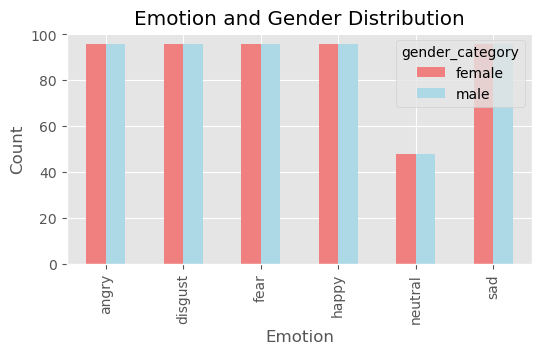

In [75]:
def plot_emotion_gender_distribution(dataframe): 
    count_table = dataframe.groupby(['emotion_label', 'gender_category']).count()
    pivot_table = count_table.pivot_table(index='emotion_label', columns='gender_category', values='file_path')

    pivot_table.plot(kind='bar', figsize=(6, 3), color=['lightcoral', 'lightblue'])  # Updated colors
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()

plot_emotion_gender_distribution(ravdess_dataframe)

In [76]:
def create_wave_plot(audio_data, sampling_rate, title_text):
    plt.figure(figsize=(8, 2))
    plt.title(title_text)
    librosa.display.waveshow(audio_data, sr=sampling_rate)
    plt.show()

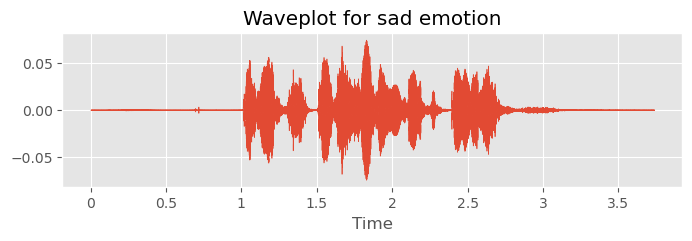

In [77]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(ravdess_dataframe.file_path[ravdess_dataframe.emotion_label == emotion_label])[1]
y, sr = librosa.load(path)

create_wave_plot(y, sr, title)
Audio(path)

In [78]:
ravdess_df_train = ravdess_dataframe[ravdess_dataframe['emotion_label']!='neutral']
ravdess_df_train

,file_path,gender_category,emotion_label
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust
...,...,...,...
1050,./Ravdess/audio_speech_actors_01-24/Actor_08/0...,female,disgust
1051,./Ravdess/audio_speech_actors_01-24/Actor_08/0...,female,disgust
1052,./Ravdess/audio_speech_actors_01-24/Actor_08/0...,female,sad
1053,./Ravdess/audio_speech_actors_01-24/Actor_08/0...,female,happy


In [82]:
mfcc_features_list = []
extracted_features_list = []
emotion_labels = []

for row in ravdess_df_train.itertuples(index=False):
    try: 
        _, sample_rate = librosa.load(path=row.file_path, sr=None) 
        raw_sound = AudioSegment.from_file(row.file_path) 
        normalized_sound = effects.normalize(raw_sound, headroom=0)
        normalized_x = np.array(normalized_sound.get_array_of_samples(), dtype='float32')

        mfcc_features = librosa.feature.mfcc(y=normalized_x, sr=sample_rate, n_mfcc=128)
        mfcc_features_mean = np.mean(mfcc_features.T, axis=0)
        extracted_features_list.append([mfcc_features_mean, row.emotion_label])
    except:
        print(f"Failed for path: {row.file_path}")

In [88]:
extracted_features_dataframe = pd.DataFrame(extracted_features_list, columns=('features', 'emotion_label'))
extracted_features_dataframe.tail()

,features,emotion_label
955,"[606.02527, 75.70522, 13.94076, 18.86165, 6.82...",disgust
956,"[639.45013, 66.4096, 11.9854965, 20.301847, 5....",disgust
957,"[655.0799, 88.06583, -0.2098536, 15.457284, 9....",sad
958,"[652.43317, 75.493805, -17.445332, 2.7181756, ...",happy
959,"[593.22766, 76.22169, -5.0607634, 12.962386, 1...",happy


In [89]:
extracted_features_dataframe.emotion_label.value_counts()

angry      192
fear       192
disgust    192
sad        192
happy      192
Name: emotion_label, dtype: int64

In [90]:
x=np.array(extracted_features_dataframe['features'].tolist())
y=np.array(extracted_features_dataframe['emotion_label'].tolist())

In [91]:
print(x.shape,y.shape)

(960, 128) (960,)


In [92]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [93]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.15,random_state=0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(816, 128) (144, 128) (816, 5) (144, 5)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(128,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train, y_train, epochs=40, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/40
51/51 [==============================] - 0s 4ms/step - loss: 9.5392 - accuracy: 0.2083 - precision: 0.2077 - recall: 0.1850 - auc: 0.5140 - val_loss: 2.2965 - val_accuracy: 0.3333 - val_precision: 0.3445 - val_recall: 0.2847 - val_auc: 0.6054
Epoch 2/40
51/51 [==============================] - 0s 2ms/step - loss: 2.0993 - accuracy: 0.2966 - precision: 0.3245 - recall: 0.2255 - auc: 0.6221 - val_loss: 1.9176 - val_accuracy: 0.2847 - val_precision: 0.3148 - val_recall: 0.2361 - val_auc: 0.6225
Epoch 3/40
51/51 [==============================] - 0s 2ms/step - loss: 2.0630 - accuracy: 0.3088 - precision: 0.3394 - recall: 0.2292 - auc: 0.6240 - val_loss: 2.0512 - val_accuracy: 0.2222 - val_precision: 0.2544 - val_recall: 0.2014 - val_auc: 0.6423
Epoch 4/40
51/51 [==============================] - 0s 2ms/step - loss: 1.8969 - accuracy: 0.3456 - precision: 0.3876 - recall: 0.2451 - auc: 0.6468 - val_loss: 1.6274 - val_accuracy: 0.3889 - val_precision: 0.4757 - val_recall: 0.3403 - 

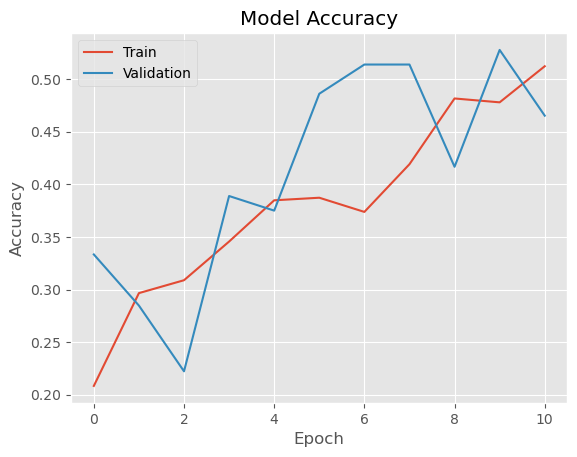

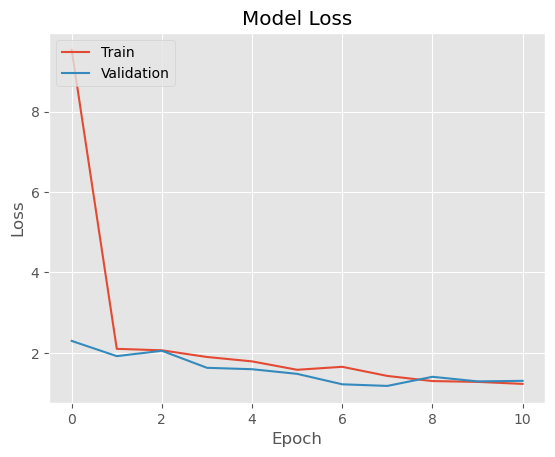

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Will add some more additional data to get more accuracy
https://tspace.library.utoronto.ca/handle/1807/24487

In [94]:
tess_directory = './Ravdess/TESS Toronto emotional speech set data/'
tess_directory_list = os.listdir(tess_directory)
file_path_list = []
gender_list = []
emotion_label_list = [] 

emotion_dictionary = {
    'happy': 'happy',
    'neutral': 'neutral',
    'sad': 'sad',
    'angry': 'angry',
    'fear': 'fear',
    'disgust': 'disgust',
}

for directory in tess_directory_list:
    audio_files = os.listdir(os.path.join(tess_directory, directory))
    for audio_file in audio_files:
        file_name_parts = audio_file.split('.')[0].split('_')
        key = file_name_parts[2]
        if key in emotion_dictionary:
            file_path_list.append(f"{tess_directory}{directory}/{audio_file}") 
            gender_list.append('female')  # Female only dataset
            emotion_label_list.append(emotion_dictionary[key])
            
tess_dataframe = pd.DataFrame({
    'file_path': file_path_list,
    'gender_category': gender_list,
    'emotion_label': emotion_label_list
})

tess_dataframe.head()

,file_path,gender_category,emotion_label
0,./Ravdess/TESS Toronto emotional speech set da...,female,disgust
1,./Ravdess/TESS Toronto emotional speech set da...,female,disgust
2,./Ravdess/TESS Toronto emotional speech set da...,female,disgust
3,./Ravdess/TESS Toronto emotional speech set da...,female,disgust
4,./Ravdess/TESS Toronto emotional speech set da...,female,disgust


In [95]:
df = pd.concat([ravdess_dataframe, tess_dataframe], axis=0).reset_index(drop=True)

In [97]:
df['file_path'][0]

'./Ravdess/audio_speech_actors_01-24/Actor_16/03-01-05-01-02-01-16.wav'

In [98]:
df.head()

,file_path,gender_category,emotion_label
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust


In [99]:
df['emotion_label'].value_counts()

angry      592
fear       592
disgust    592
sad        592
happy      592
neutral     96
Name: emotion_label, dtype: int64

In [101]:
df_train = df[df['emotion_label']!='neutral']
df_train

,file_path,gender_category,emotion_label
0,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
1,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
2,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,fear
3,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,angry
4,./Ravdess/audio_speech_actors_01-24/Actor_16/0...,female,disgust
...,...,...,...
3051,./Ravdess/TESS Toronto emotional speech set da...,female,sad
3052,./Ravdess/TESS Toronto emotional speech set da...,female,sad
3053,./Ravdess/TESS Toronto emotional speech set da...,female,sad
3054,./Ravdess/TESS Toronto emotional speech set da...,female,sad


In [102]:
mfcc_features_list = []
extracted_features_list = []
emotion_labels = []

for row in ravdess_df_train.itertuples(index=False):
    try: 
        _, sample_rate = librosa.load(path=row.file_path, sr=None) 
        raw_sound = AudioSegment.from_file(row.file_path) 
        normalized_sound = effects.normalize(raw_sound, headroom=0)
        normalized_x = np.array(normalized_sound.get_array_of_samples(), dtype='float32')

        mfcc_features = librosa.feature.mfcc(y=normalized_x, sr=sample_rate, n_mfcc=128)
        mfcc_features_mean = np.mean(mfcc_features.T, axis=0)
        extracted_features_list.append([mfcc_features_mean, row.emotion_label])
    except:
        print(f"Failed for path: {row.file_path}")

In [103]:
extracted_features_dataframe = pd.DataFrame(extracted_features_list, columns=('features', 'emotion_label'))
extracted_features_dataframe.tail()

,features,emotion_label
955,"[606.02527, 75.70522, 13.94076, 18.86165, 6.82...",disgust
956,"[639.45013, 66.4096, 11.9854965, 20.301847, 5....",disgust
957,"[655.0799, 88.06583, -0.2098536, 15.457284, 9....",sad
958,"[652.43317, 75.493805, -17.445332, 2.7181756, ...",happy
959,"[593.22766, 76.22169, -5.0607634, 12.962386, 1...",happy


In [104]:
extracted_features_dataframe.emotion_label.value_counts()

angry      192
fear       192
disgust    192
sad        192
happy      192
Name: emotion_label, dtype: int64

In [106]:
x=np.array(extracted_features_dataframe['features'].tolist())
y=np.array(extracted_features_dataframe['emotion_label'].tolist())

In [107]:
print(x.shape,y.shape)

(960, 128) (960,)


In [108]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [109]:
y.shape

(960, 5)

In [110]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.15,random_state=0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(816, 128) (144, 128) (816, 5) (144, 5)


In [34]:
model2=Sequential()
model2.add(Dense(256,activation='relu',input_shape=(128,)))
model2.add(Dense(256,activation='relu'))
model2.add(Dense(256,activation='relu'))
model2.add(Dense(5,activation='softmax'))
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','Precision','Recall','AUC'])

In [35]:
model2 = model2.fit(X_train,y_train,epochs=40,batch_size=16,validation_data=(X_test,y_test))

Epoch 1/40
158/158 [==============================] - 1s 2ms/step - loss: 3.9633 - accuracy: 0.5382 - precision: 0.5660 - recall: 0.5068 - auc: 0.7843 - val_loss: 1.1605 - val_accuracy: 0.5901 - val_precision: 0.6640 - val_recall: 0.5563 - val_auc: 0.8699
Epoch 2/40
158/158 [==============================] - 0s 2ms/step - loss: 0.9113 - accuracy: 0.6997 - precision: 0.7490 - recall: 0.6635 - auc: 0.9153 - val_loss: 0.9033 - val_accuracy: 0.6757 - val_precision: 0.7250 - val_recall: 0.6532 - val_auc: 0.9139
Epoch 3/40
158/158 [==============================] - 0s 2ms/step - loss: 0.7962 - accuracy: 0.7391 - precision: 0.7991 - recall: 0.7104 - auc: 0.9338 - val_loss: 1.2383 - val_accuracy: 0.6239 - val_precision: 0.6700 - val_recall: 0.6036 - val_auc: 0.8753
Epoch 4/40
158/158 [==============================] - 0s 2ms/step - loss: 0.6442 - accuracy: 0.7749 - precision: 0.8371 - recall: 0.7359 - auc: 0.9522 - val_loss: 0.9259 - val_accuracy: 0.6982 - val_precision: 0.8057 - val_recall: 0

Epoch 33/40
158/158 [==============================] - 0s 2ms/step - loss: 0.2508 - accuracy: 0.9089 - precision: 0.9341 - recall: 0.8850 - auc: 0.9915 - val_loss: 0.3552 - val_accuracy: 0.8716 - val_precision: 0.9126 - val_recall: 0.8468 - val_auc: 0.9823
Epoch 34/40
158/158 [==============================] - 0s 2ms/step - loss: 0.1764 - accuracy: 0.9344 - precision: 0.9519 - recall: 0.9200 - auc: 0.9959 - val_loss: 0.4757 - val_accuracy: 0.8626 - val_precision: 0.8707 - val_recall: 0.8491 - val_auc: 0.9741
Epoch 35/40
158/158 [==============================] - 0s 2ms/step - loss: 0.1627 - accuracy: 0.9395 - precision: 0.9546 - recall: 0.9284 - auc: 0.9964 - val_loss: 0.4580 - val_accuracy: 0.8514 - val_precision: 0.8726 - val_recall: 0.8333 - val_auc: 0.9777
Epoch 36/40
158/158 [==============================] - 0s 2ms/step - loss: 0.1373 - accuracy: 0.9499 - precision: 0.9638 - recall: 0.9415 - auc: 0.9974 - val_loss: 0.4923 - val_accuracy: 0.8559 - val_precision: 0.8724 - val_recal

In [43]:
# dir(model)

In [37]:
model2.model.evaluate(X_train,y_train)

79/79 [==============================] - 0s 841us/step - loss: 0.1363 - accuracy: 0.9459 - precision: 0.9635 - recall: 0.9336 - auc: 0.9975


[0.13632483780384064,
 0.945902943611145,
 0.9634646773338318,
 0.933571994304657,
 0.997463047504425]

In [40]:
model2.model.evaluate(X_test,y_test)

14/14 [==============================] - 0s 1ms/step - loss: 0.3690 - accuracy: 0.8694 - precision: 0.9031 - recall: 0.8604 - auc: 0.9825


[0.3689592480659485,
 0.869369387626648,
 0.9030733108520508,
 0.8603603839874268,
 0.9824727773666382]

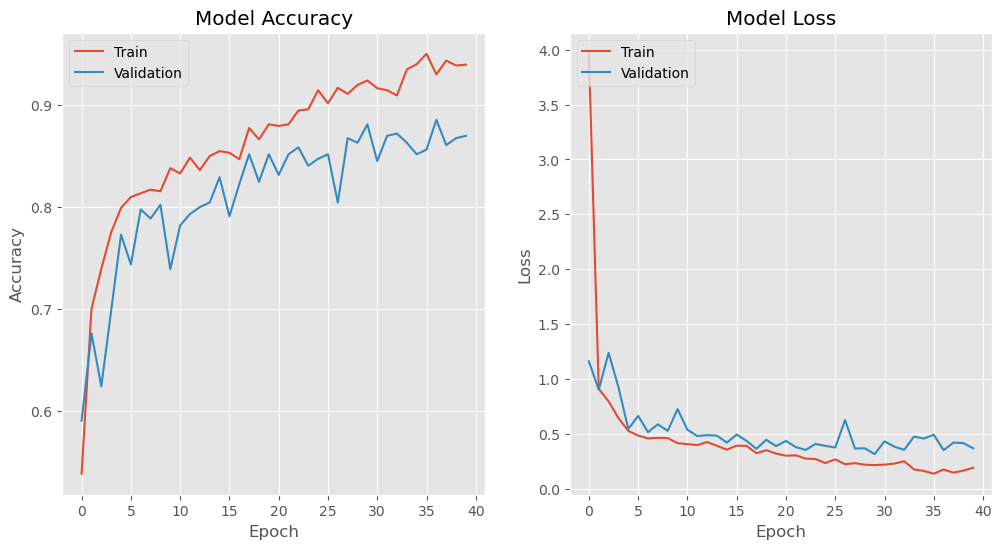

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model2.history['accuracy'])
plt.plot(model2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model2.history['loss'])
plt.plot(model2.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [41]:
extracted_features['op_labels'].unique()

array(['angry', 'fear', 'disgust', 'sad', 'happy'], dtype=object)

1/1 [==============================] - 0s 132ms/step
angry


With LSTM Layer

In [46]:
model3 = Sequential()
model3.add(LSTM(256, input_shape=(128,1)))  # LSTM layer added
model3.add(Dense(256, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(5, activation='softmax'))
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [48]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dense_10 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 397061 (1.51 MB)
Trainable params: 397061 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
model3 = model3.fit(X_train,y_train,epochs=40,batch_size=16,validation_data=(X_test,y_test))

Epoch 1/40
158/158 [==============================] - 15s 97ms/step - loss: 1.5499 - accuracy: 0.2737 - precision: 0.6875 - recall: 0.0175 - auc: 0.6117 - val_loss: 1.5437 - val_accuracy: 0.3018 - val_precision: 0.8750 - val_recall: 0.0158 - val_auc: 0.6116
Epoch 2/40
158/158 [==============================] - 15s 93ms/step - loss: 1.5383 - accuracy: 0.3063 - precision: 0.6480 - recall: 0.0322 - auc: 0.6360 - val_loss: 1.4130 - val_accuracy: 0.3514 - val_precision: 0.8167 - val_recall: 0.1104 - val_auc: 0.6879
Epoch 3/40
158/158 [==============================] - 15s 94ms/step - loss: 1.4705 - accuracy: 0.3433 - precision: 0.6691 - recall: 0.0716 - auc: 0.6724 - val_loss: 1.4234 - val_accuracy: 0.3514 - val_precision: 0.9189 - val_recall: 0.0766 - val_auc: 0.7004
Epoch 4/40
158/158 [==============================] - 15s 93ms/step - loss: 1.3820 - accuracy: 0.3890 - precision: 0.6973 - recall: 0.1146 - auc: 0.7226 - val_loss: 1.3219 - val_accuracy: 0.4234 - val_precision: 0.7471 - val_r

Epoch 33/40
158/158 [==============================] - 14s 89ms/step - loss: 0.5678 - accuracy: 0.7737 - precision: 0.9435 - recall: 0.6643 - auc: 0.9577 - val_loss: 0.6037 - val_accuracy: 0.7297 - val_precision: 0.9444 - val_recall: 0.6509 - val_auc: 0.9466
Epoch 34/40
158/158 [==============================] - 15s 92ms/step - loss: 0.4895 - accuracy: 0.7967 - precision: 0.9440 - recall: 0.6977 - auc: 0.9678 - val_loss: 0.6190 - val_accuracy: 0.7185 - val_precision: 0.9430 - val_recall: 0.6329 - val_auc: 0.9448
Epoch 35/40
158/158 [==============================] - 15s 93ms/step - loss: 0.4800 - accuracy: 0.8007 - precision: 0.9493 - recall: 0.7068 - auc: 0.9688 - val_loss: 0.5706 - val_accuracy: 0.7545 - val_precision: 0.9672 - val_recall: 0.6644 - val_auc: 0.9520
Epoch 36/40
158/158 [==============================] - 14s 87ms/step - loss: 0.4550 - accuracy: 0.8103 - precision: 0.9580 - recall: 0.7160 - auc: 0.9722 - val_loss: 0.6128 - val_accuracy: 0.7185 - val_precision: 0.9596 - v

In [50]:
model3.model.evaluate(X_train,y_train)

79/79 [==============================] - 3s 41ms/step - loss: 0.4220 - accuracy: 0.8345 - precision: 0.9751 - recall: 0.7176 - auc: 0.9777


[0.42201051115989685,
 0.8345266580581665,
 0.9751351475715637,
 0.717581570148468,
 0.9777267575263977]

In [51]:
model3.model.evaluate(X_test,y_test)

14/14 [==============================] - 1s 41ms/step - loss: 0.5930 - accuracy: 0.7387 - precision: 0.9515 - recall: 0.6622 - auc: 0.9490


[0.5929834246635437,
 0.7387387156486511,
 0.9514563083648682,
 0.662162184715271,
 0.9490091800689697]

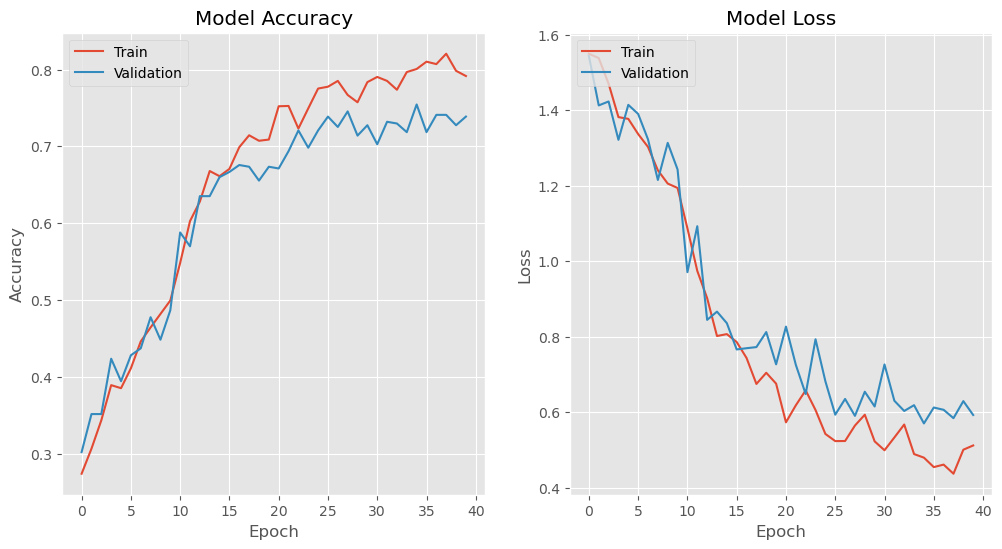

In [52]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model3.history['accuracy'])
plt.plot(model3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model3.history['loss'])
plt.plot(model3.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [54]:
dir(model3.model)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__annotations__',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_aggregate_exact_metrics',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_config',
 '_auto_get_config',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_graph_network_for_inferred_shape',
 '_build_input_shape',
 '_call_spec',
 '_callable_losses',
 '_captured_weight_regularizer',
 '_cast_single

In [56]:
model3.model.save('EmotionLSTM.h5')
model2.model.save('EmotionNN.h5')

In [111]:
import pickle
with open('label_encoder.pkl', 'wb') as le_file:
    pickle.dump(labelencoder, le_file)

In [116]:
#for testing run this
from tensorflow.keras.models import load_model
loaded_modelNN = load_model('EmotionNN.h5')
loaded_modelLstm = load_model('EmotionLSTM.h5')

5/5 [==============================] - 0s 940us/step


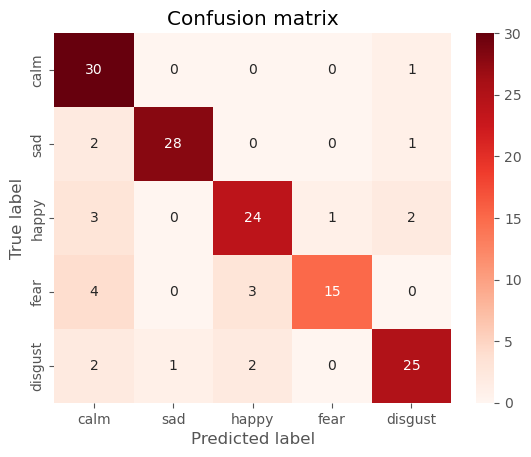

In [117]:
##NN
y_pred = np.argmax(loaded_modelNN.predict(X_test), axis=1)
labels = ['calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred, labels=range(5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

5/5 [==============================] - 0s 35ms/step


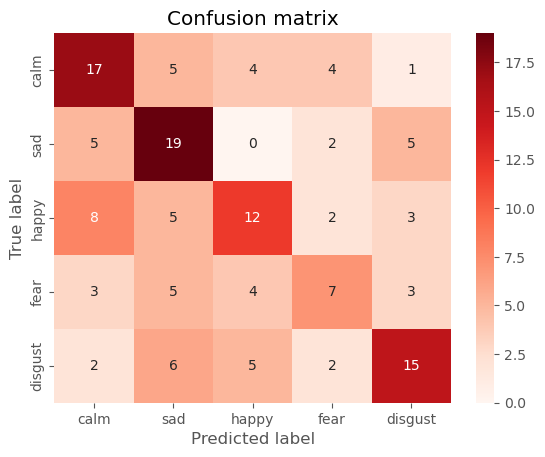

In [118]:
##LSTM

##NN
y_pred = np.argmax(loaded_modelLstm.predict(X_test), axis=1)
labels = ['calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred, labels=range(5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [113]:
#for testing run this
with open('label_encoder.pkl', 'rb') as le_file:
    loaded_label_encoder = pickle.load(le_file)

In [ ]:
#for testing run this
!pip install librosa
!pip install pydub

In [114]:
#for testing run this

import librosa
import numpy as np
from pydub import AudioSegment, effects

file_path = "./Ravdess/TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav"

def classify_audio(file_path):
    audio_data, sample_rate = librosa.load(file_path)
    raw_sound = AudioSegment.from_file(file_path)
    normalized_sound = effects.normalize(raw_sound, headroom=0)
    normalized_x = np.array(normalized_sound.get_array_of_samples(), dtype='float32')
    mfcc_features = librosa.feature.mfcc(y=normalized_x, sr=sample_rate, n_mfcc=128)  # MFCC
    mfcc_features_mean = np.mean(mfcc_features.T, axis=0)
    reshaped_features = mfcc_features_mean.reshape(1, -1)
    predicted_label = loaded_model.predict(reshaped_features)
    indices = np.argmax(predicted_label, axis=1)
    predicted_class = loaded_label_encoder.inverse_transform(indices)
    return predicted_class[0]


classify_audio(filename)


1/1 [==============================] - 0s 38ms/step


'angry'